In [1]:
import numpy as np
from qutip import tensor, basis, ket2dm
from qutip_qip.circuit import QubitCircuit
from chalmers_qubit.sarimner import (
    SarimnerProcessor, SarimnerModel, SarimnerCompiler, DecoherenceNoise
)
from chalmers_qubit.base.operations import project_on_qubit

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Single Qubit Gate Example
We begin by creating a quantum circuit that has two qubits, and we independently perform two single-qubit gates on them

In [2]:
num_qubits = 2
circuit = QubitCircuit(num_qubits)

circuit.add_gate("RX", targets=0, arg_value=np.pi/2)
circuit.add_gate("RY", targets=1, arg_value=np.pi/2)
circuit.add_gate("RY", targets=0, arg_value=np.pi)
circuit.add_gate("GLOBALPHASE", targets=0, arg_value=np.pi/2)

Next we define the hardware parameters that we will use when simulating this quantum circtuit. We therefore define:
- `qubit_frequencies`: List of the qubit frequency of each qubit defined in GHz.
- `anharmonicities`: List of the qubit anharmonicitues of each qubit defined in GHz.
- `cpl_matrix`: Coupling matrix where the element $(i,j)$ defines the coupling strength between qubit $i$ and qubit $j$ in GHz.
- `t1`: List with relaxation times $T_1$ for each qubit in nano seconds.
- `t2`: List with pure dephasing times $T_2$ for each qubit in nano seconds.

In [3]:
# Qubit frequencies in (GHz)
qubit_frequencies = [2 * np.pi * 5.0, 2 * np.pi * 5.4]
# Anharmonicity in (GHz)
anharmonicities = [- 2 * np.pi * 0.3, - 2 * np.pi * 0.3]
# Coupling matrix
coupling_matrix = np.array([[0, 2 * np.pi * 1e-3], [0, 0]])
# T1's and T2's for the qubits in (ns)
t1 = [60] * num_qubits
t2 = [100] * num_qubits

Next we take these hardware parameters that we have defined and we load them onto our superconducting hardware model `SarimnerModel`. This along with the `compiler` and `noise` is given to `SarimnerProcessor`.

In [4]:
# Load the physical parameters onto the model
model = SarimnerModel(qubit_frequencies=qubit_frequencies, 
                      anharmonicities=anharmonicities, 
                      coupling_matrix=coupling_matrix)

# Choose compiler
compiler = SarimnerCompiler(model=model)

# Add noise
noise = [DecoherenceNoise(t1=t1, t2=t2)]

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)

Once we have defined our processor we can load the quantum circuit onto the processor. This will compile the circuit into a pulse sequence.

In [5]:
tlist, coeffs = sarimner.load_circuit(circuit)

We can choose to plot the pulse sequence

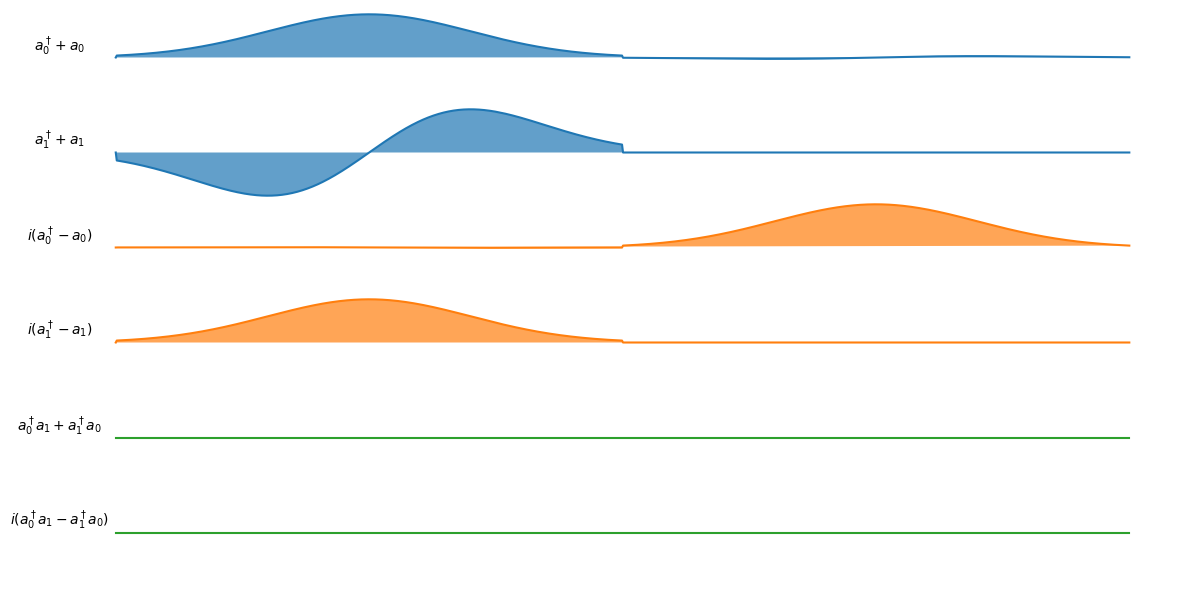

In [6]:
sarimner.plot_pulses();

Now we can exectue this pulse sequence on the processor by using `run_state` with a given `initial state`

In [7]:
initial_state = tensor(basis(3,0), basis(3,0))
result = sarimner.run_state(initial_state)
final_state = result.states[-1]
final_state

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 3.96639704e-01+3.14255814e-18j  1.17484656e-01+9.56464394e-05j
  -2.12326244e-06-6.27321143e-05j  1.07897771e-01+2.13526783e-01j
   3.19078355e-02+6.32726586e-02j  3.31878794e-05-1.82249077e-05j
   3.35860315e-04-4.06608413e-04j  9.95708586e-05-1.20362451e-04j
  -6.81983252e-08-5.17076616e-08j]
 [ 1.17484656e-01-9.56464394e-05j  6.63490448e-02+3.02207115e-18j
  -1.50804299e-06-4.18399291e-05j  3.20108170e-02+6.32206208e-02j
   1.80489281e-02+3.57183319e-02j  2.21100756e-05-1.22047913e-05j
   9.93747486e-05-1.20524396e-04j  5.61743460e-05-6.80218591e-05j
  -4.55730660e-08-3.43782839e-08j]
 [-2.12326244e-06+6.27321143e-05j -1.50804299e-06+4.18399291e-05j
   2.49382200e-07-2.53162463e-22j -3.43602304e-05+1.59333871e-05j
  -2.29421359e-05+1.05775081e-05j  6.78382459e-08+1.34249094e-07j
   6.23977133e-08+5.54218772e-08j  4.15373809e-08+3.70548889e-08j
   2.11153150e-10-2.55679979e-10j]


Since we simulated the system for a three-level system we have to project it onto the computational subspace using the function `project_on_qubit`

In [8]:
project_on_qubit(final_state)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.3966397 +3.14255814e-18j 0.11748466+9.56464394e-05j
  0.10789777+2.13526783e-01j 0.03190784+6.32726586e-02j]
 [0.11748466-9.56464394e-05j 0.06634904+3.02207115e-18j
  0.03201082+6.32206208e-02j 0.01804893+3.57183319e-02j]
 [0.10789777-2.13526783e-01j 0.03201082-6.32206208e-02j
  0.46002638-2.84134393e-18j 0.13625982+1.10933833e-04j]
 [0.03190784-6.32726586e-02j 0.01804893-3.57183319e-02j
  0.13625982-1.10933833e-04j 0.07695233-3.20443076e-18j]]

# Two Qubit Gate Example

Next we show a simple circuit using a two-qubit `CZ`-gate and how to compile it onto our processor.

In [9]:
# Define a circuit and run the simulation
num_qubits = 2
circuit = QubitCircuit(num_qubits)
circuit.add_gate("CZ", controls=0, targets=1)

Just as before we start by defining our hardware parameters

In [10]:
# Qubit frequencies in (GHz)
qubit_frequencies = [2 * np.pi * 5.0, 2 * np.pi * 5.4]
# Anharmonicity in (GHz)
anharmonicities = [- 2 * np.pi * 0.3, - 2 * np.pi * 0.3]
# T1's and T2's for the qubits in (ns)
t1 = [60 * 1e3, 80 * 1e3]
t2 = [100 * 1e3, 105 * 1e3]

# Times in (ns)
t = 100
# corresponding coupling
g = np.sqrt(2) * np.pi / t
# Coupling matrix
coupling_matrix = np.array([[0, g],
                       [0, 0]])

and load them onto our model

In [11]:
# Load the physical parameters onto the model
model = SarimnerModel(
    qubit_frequencies=qubit_frequencies,
    anharmonicities=anharmonicities,
    coupling_matrix=coupling_matrix,
)

# Choose compiler
compiler = SarimnerCompiler(model=model)

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler)

then we can compile the circuit onto our processor

In [12]:
tlist, coeffs = sarimner.load_circuit(circuit)

and plot the pulses

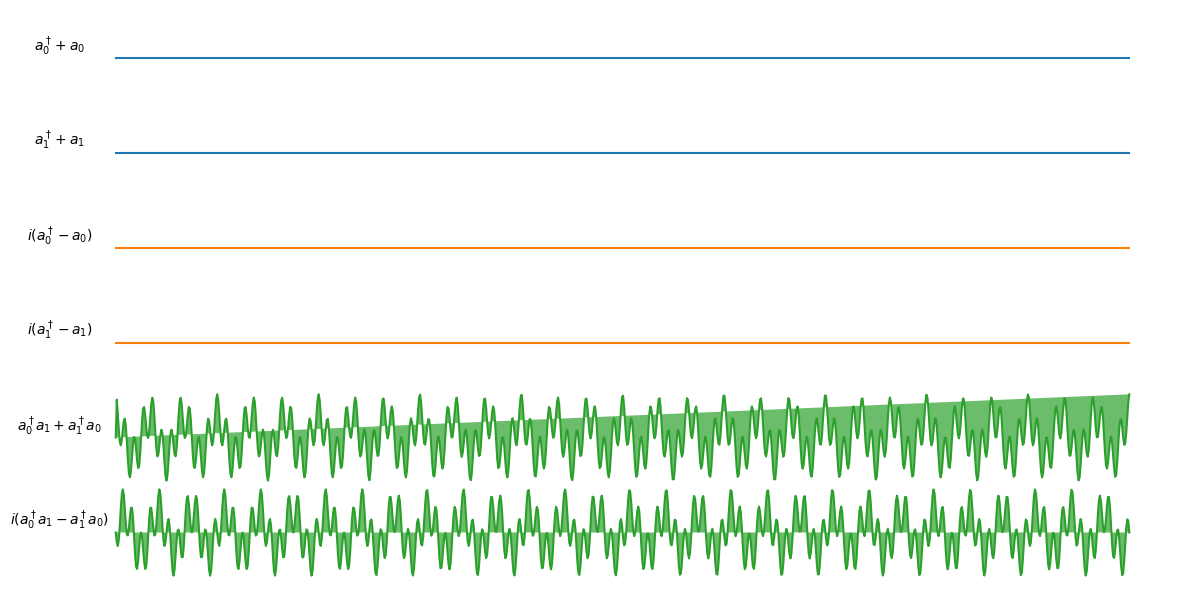

In [13]:
sarimner.plot_pulses();

To see that the CZ-gate is implemented correctly we will now simulate the circuit using the master equation simulation and look at the expectation values of the $|11\rangle$ and $|20\rangle$ states.

In [14]:
ket11 = tensor(basis(3,1),basis(3,1))
ket20 = tensor(basis(3,2),basis(3,0))
# List of operators we wanna compute the expectation value for during the simulation
e_ops = [ket2dm(ket11), ket2dm(ket20)]
result = sarimner.run_state(ket11, e_ops=e_ops, options={'nsteps': 1e5, 'store_final_state': True})

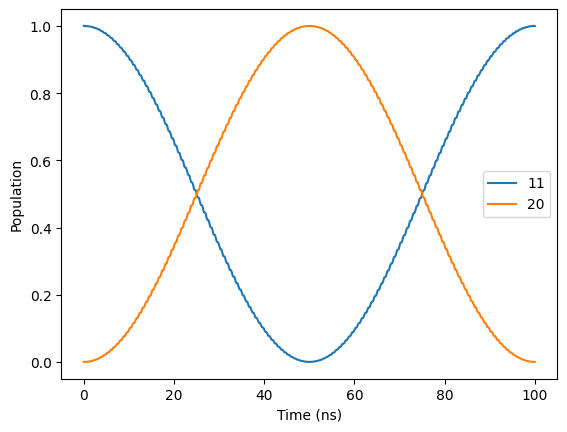

In [15]:
import matplotlib.pyplot as plt
plt.plot(result.times,result.expect[0],label='11')
plt.plot(result.times,result.expect[1],label='20')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.legend()

And if we print the final state we see that the $|11\rangle$ state has the desired $-1$ phase.

In [16]:
qubit_state = project_on_qubit(result.final_state)
qubit_state

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.99998107+0.00421728j]]

## Three Qubit Gate Example

Finally we will demonstrate the implementation of the three-qubit gate.

Since this gate is not part of qutip `QubitCircuit` we have to defined the gate ourself and supply as `user_gates`

In [17]:
# Ideal gate
def cczs(args):
    theta, phi, gamma = args
    U = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, -np.exp(-1j*gamma)*np.sin(theta/2)**2 + np.cos(theta/2)**2, 
                                    (1/2)*(1 + np.exp(-1j*gamma))*np.exp(-1j*phi)*np.sin(theta), 0],
                  [0, 0, 0, 0, 0, (1/2)*(1 + np.exp(-1j*gamma))*np.exp(1j*phi)*np.sin(theta), 
                                    -np.exp(-1j*gamma)*np.cos(theta/2)**2 + np.sin(theta/2)**2, 0],
                  [0, 0, 0, 0, 0, 0, 0, -np.exp(1j*gamma)]], dtype="complex")
    return Qobj(U, dims=[[2]*3, [2]*3])

In [18]:
# Define a circuit and run the simulation
num_qubits = 3

circuit = QubitCircuit(num_qubits)
circuit.user_gates = {"CCZS": cczs}
circuit.add_gate("CCZS", targets=[0,1,2], arg_value=[np.pi/2,np.pi,0])

In [19]:
# Qubit frequencies in (GHz)
qubit_frequencies = [2 * np.pi * 5.0, 2 * np.pi * 5.4, 2 * np.pi * 5.2]
# Anharmonicity in (GHz)
anharmonicities = [- 2 * np.pi * 0.3, - 2 * np.pi * 0.3, - 2 * np.pi * 0.3]
# T1's and T2's for the qubits in (ns)
t1 = [60] * num_qubits
t2 = [100] * num_qubits
# Times in (ns)
t = 100
# corresponding coupling
g = np.sqrt(2) * np.pi / t
# Coupling matrix in (GHz)
coupling_matrix = np.array([[0, g, g], [0, 0, 0], [0, 0, 0]])

In [20]:
# Load the physical parameters onto the model
model = SarimnerModel(
    qubit_frequencies=qubit_frequencies,
    anharmonicities=anharmonicities,
    coupling_matrix=coupling_matrix,
)

# Choose compiler
compiler = SarimnerCompiler(model=model)

# Add noise
noise = [DecoherenceNoise(t1=t1, t2=t2)]

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=[])

In [21]:
tlist, coeffs = sarimner.load_circuit(circuit)

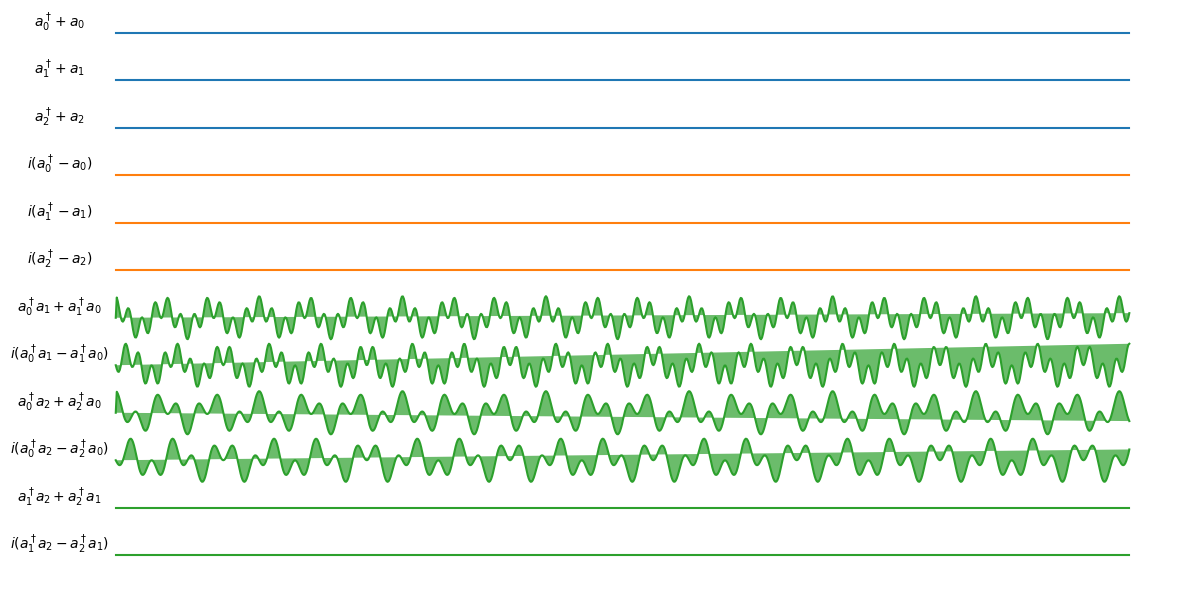

In [22]:
sarimner.plot_pulses();

In [23]:
ket110 = tensor([basis(3,1),basis(3,1),basis(3,0)])
ket101 = tensor([basis(3,1),basis(3,0),basis(3,1)])
ket200 = tensor([basis(3,2),basis(3,0),basis(3,0)])
e_ops = [ket2dm(ket110), ket2dm(ket101), ket2dm(ket200)]
result = sarimner.run_state(ket110, e_ops=e_ops, options={'store_states':True})

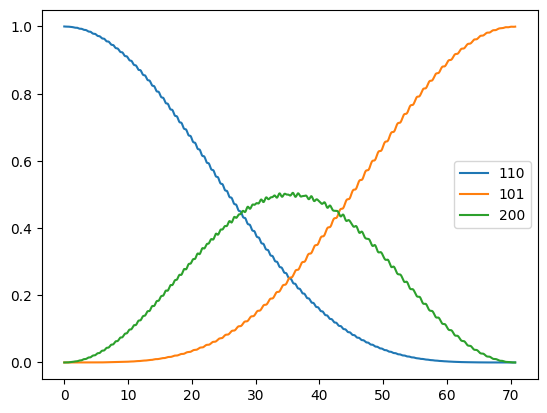

In [24]:
import matplotlib.pyplot as plt
plt.plot(result.times,result.expect[0], label="110")
plt.plot(result.times,result.expect[1], label="101")
plt.plot(result.times,result.expect[2], label="200")
plt.legend()